In [32]:
my_lib = r'/media/AsustorThree_Public/Tutorials/myClimPy/'
import datetime; regenerate= f'http://www.climsystems.com Lu.S {datetime.date.today()}'

import sys
if my_lib not in sys.path:
    sys.path.append(my_lib) 

import numpy as np
import xarray as xr
from pathlib import Path

import re,os, gc, tqdm

from mycdat.droughts import resample_to_time
from mycdat.droughts import inputwater, waterdeficit
from mycdat.droughts import pet_hg,pet_tw48
from mycdat.patterns import read_dgmt, read_var_ptn

def preprocess(ds):
    # ds = ds.drop('wgs_1984', errors='ignore')
    matching_dims = [dim for dim in ds.dims if 'longitude' in dim.lower() or 'latitude' in dim.lower()]
    rename_dict = {dim: 'lon' if 'longitude' in dim.lower() else 'lat' for dim in matching_dims}
    ds = ds.rename(rename_dict)
    ds = ds.rename({i:i.lower() 
                    if i.lower() in ['points','time','year','month','depth'] 
                    else i.lower()[:3] for i in ds.coords}
                  )
    ds['lat'] = ds['lat'].astype('float32')
    ds['lon'] = ds['lon'].astype('float32')
    # if max(ds.lon) > 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)); ds = ds.sortby(ds.lon); ds = ds.sortby(ds.lat, ascending=False)
    # # else:
    # ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)); ds = ds.sortby(['lon', 'lat']); ds = ds.sortby(ds.lat, ascending=False)
    #ds = ds.sortby(ds.lon); ds = ds.sortby(ds.lat, ascending=False)
    return ds

## 0. Interpolating the solar radiation to precipitation grid & output monthly results

In [34]:
# solar_dir= Path("/home/lusun/LuSUN/Data")
# precip_dir=Path("/home/lusun/LuSUN/Data/NC_1962-2020/")
# chunks = {'time':-1}

# for i in range(1991,2021):
#     print(i)
#     year=str(i)
#     precip_files = list(sorted(precip_dir.joinpath("prec").glob("*prec*.nc4")))
#     da_precip = xr.open_mfdataset(precip_files, 
# #                           preprocess=preprocess, 
#                               chunks=chunks).prec.sel(time=slice(year,year)) #"1991", '2020'

#     solar_files = list(sorted(solar_dir.joinpath("ANUClimate_monthly").glob("*srad*.nc")))
#     da_solar_mon = xr.open_mfdataset(solar_files, 
# #                           preprocess=preprocess, 
#                               chunks=chunks).srad.sel(time=slice(year,year)) #chunks=chunks

#     da_solar_mon = da_solar_mon.astype(np.float32)

#     da_precip_mon = da_precip.resample(time="1M").sum()

#     da_solar_mon['time'] = da_precip_mon['time']

#     out_dir=Path("/home/lusun/LuSUN/Data")
#     region="Australia"
    
#     var_name='prec'

#     da_precip_mon.attrs = da_precip.attrs.copy()
#     da_precip_mon.attrs['units'] = 'mm/month'
#     da_precip_mon.attrs['regenerate'] = regenerate

#     out_file = out_dir.joinpath(f"{region}_{var_name}_monthly_{year}.nc")
#     da_precip_mon.to_dataset(name=f"{var_name}").to_netcdf(out_file)
    
#     da_solar_mon_interploted=da_solar_mon.interp_like(da_precip_mon)
    
#     var_name='srad'

#     da_solar_mon_interploted.attrs =  da_solar_mon.attrs.copy()
#     da_solar_mon_interploted.attrs['regenerate'] = regenerate

#     out_file = out_dir.joinpath(f"{region}_{var_name}_monthly_{year}.nc")
#     da_solar_mon_interploted.to_dataset(name=f"{var_name}").to_netcdf(out_file)

In [35]:
# tmax_dir= Path("/home/lusun/LuSUN/Data/NC_1962-2020/")
# tmin_dir= Path("/home/lusun/LuSUN/Data/NC_1962-2020/")
# chunks = {'time':-1}

# for i in range(1991,2021):
#     print(i)
#     year=str(i)
#     tmax_files = list(sorted(tmax_dir.joinpath("tmax").glob("*tmax*.nc4")))
#     da_tmax = xr.open_mfdataset(tmax_files, 
# #                           preprocess=preprocess, 
#                               chunks=chunks).tmax.sel(time=slice(year,year)) #"1991", '2020'

#     tmin_files = list(sorted(tmin_dir.joinpath("tmin").glob("*tmin*.nc4")))
#     da_tmin = xr.open_mfdataset(tmin_files, 
# #                           preprocess=preprocess, 
#                               chunks=chunks).tmin.sel(time=slice(year,year)) #chunks=chunks

#     da_tmax_mon=da_tmax.resample(time="1M").mean()
#     da_tmin_mon=da_tmin.resample(time="1M").mean()

#     da_tmax_mon.attrs = da_tmax.attrs.copy()
#     da_tmax_mon.attrs['regenerate'] = regenerate

#     da_tmin_mon.attrs = da_tmin.attrs.copy()
#     da_tmin_mon.attrs['regenerate'] = regenerate

#     out_dir=Path("/home/lusun/LuSUN/Data")
#     region="Australia"
    
#     var_name='tmax'
#     out_file = out_dir.joinpath(f"{region}_{var_name}_monthly_{year}.nc")
#     da_tmax_mon.to_dataset(name=f"{var_name}").to_netcdf(out_file)
    
#     var_name='tmin'
#     out_file = out_dir.joinpath(f"{region}_{var_name}_monthly_{year}.nc")
#     da_tmin_mon.to_dataset(name=f"{var_name}").to_netcdf(out_file)


## 1. Calculate monthly PET

In [36]:
solar_dir= Path("/home/lusun/LuSUN")
precip_dir=Path("/home/lusun/LuSUN")
tmax_dir=  Path("/home/lusun/LuSUN")
tmin_dir=  Path("/home/lusun/LuSUN")
data_dir=  Path("/home/lusun/LuSUN")


chunks = {'time':-1}

precip_files = list(sorted(precip_dir.joinpath("Data").glob("*prec*.nc")))
da_precip_mon = xr.open_mfdataset(precip_files, 
#                             engine='h5netcdf',
                            # preprocess=preprocess, 
                            chunks=chunks).prec.sel(time=slice("1991","2020")) #"1991", '2020'

solar_files = list(sorted(solar_dir.joinpath("Data").glob("*srad*.nc")))
da_solar_mon = xr.open_mfdataset(solar_files, 
                            # engine='h5netcdf',
                            # preprocess=preprocess, 
                            chunks=chunks).srad.sel(time=slice("1991","2020")) #chunks=chunks

tmax_files = list(sorted(tmax_dir.joinpath("Data").glob("*tmax*.nc")))
da_tmax_mon = xr.open_mfdataset(tmax_files, 
                            # engine='h5netcdf',
                            # preprocess=preprocess, 
                            chunks=chunks).tmax.sel(time=slice("1991","2020")) #"1991", '2020'


tmin_files = list(sorted(tmin_dir.joinpath("Data").glob("*tmin*.nc")))
da_tmin_mon = xr.open_mfdataset(tmin_files, 
                            # engine='h5netcdf',
                            # preprocess=preprocess, 
                            chunks=chunks).tmin.sel(time=slice("1991","2020")) #"1991", '2020'
da_tmean_mon=(da_tmax_mon+da_tmin_mon)/2
da_tmean_mon.attrs = da_tmax_mon.attrs.copy()



In [37]:
da_tmean_mon

<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<truediv, shape=(360, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
Attributes:
    units:       degree
    regenerate:  http://www.climsystems.com Lu.S 2023-07-05

## Baseline

In [38]:
import pandas as pd
path_ensemble=Path('/media/AsustorOne_Shared/AR6_patterns_changes_for_API')
dgmt_file = Path('IPCC_AR6_GMT_curves.csv')
df_dgmt = read_dgmt(path_ensemble, dgmt_file)

In [39]:
df_dgmt

,SSP1-1.9,SSP1-2.6,SSP2-4.5,SSP3-7.0,SSP5-8.5
Year,,,,,
2010,0.21,0.17,0.12,0.12,0.13
2015,0.38,0.33,0.26,0.25,0.27
2020,0.52,0.47,0.40,0.40,0.43
2025,0.62,0.59,0.55,0.54,0.61
2030,0.70,0.70,0.70,0.70,0.80
2035,0.75,0.79,0.85,0.86,1.01
2040,0.79,0.87,1.01,1.04,1.22
2045,0.80,0.94,1.16,1.21,1.46
2050,0.80,1.00,1.30,1.40,1.70


In [40]:
print(da_tmean_mon.attrs)

{'units': 'degree', 'regenerate': 'http://www.climsystems.com Lu.S 2023-07-05'}


In [41]:
pcts = [50.0, 5.0, 95.0]

out_var1  = "tmean"
out_dir1  = data_dir.joinpath(f'output/{out_var1}')
out_dir1.mkdir(parents=True, exist_ok=True)

out_var2  = "solar"
out_dir2  = data_dir.joinpath(f'output/{out_var2}')
out_dir2.mkdir(parents=True, exist_ok=True)

out_var3  = "precip"
out_dir3  = data_dir.joinpath(f'output/{out_var3}')
out_dir3.mkdir(parents=True, exist_ok=True)

baseline_tmean = da_tmean_mon.mean(axis = 0)
baseline_solar = da_solar_mon.mean(axis = 0)
baseline_precip = da_precip_mon.mean(axis = 0)

baseline_tmean.attrs['units'] = da_tmean_mon.units
baseline_solar.attrs['units'] = da_solar_mon.units
baseline_precip.attrs['units'] = da_precip_mon.units

baseline_tmean.attrs['regenerate'] = regenerate
baseline_solar.attrs['regenerate'] = regenerate
baseline_precip.attrs['regenerate'] = regenerate

for sce in df_dgmt.columns:
    print('\r {}'.format(f'\r -------bl------- {sce}'), end=' ')
    for pct in tqdm.tqdm(pcts):
        out_file1 = out_dir1.joinpath(f"{out_var1}.{sce}.2005.{str(int(pct)).zfill(2)}th.nc")
        if os.path.exists(out_file1): continue

        # save data
        baseline_tmean.expand_dims({'ssp':[int(''.join(re.findall(r'\d+', sce)))], 
                          'year':[2005], 'pth':[pct]}).to_dataset(name=out_var1).to_netcdf(out_file1)

    print('\r {}'.format(f'\r -------bl------- {sce}'), end=' ')
    for pct in tqdm.tqdm(pcts):
        out_file2 = out_dir2.joinpath(f"{out_var2}.{sce}.2005.{str(int(pct)).zfill(2)}th.nc")
        if os.path.exists(out_file2): continue

        # save data
        baseline_solar.expand_dims({'ssp':[int(''.join(re.findall(r'\d+', sce)))], 
                          'year':[2005], 'pth':[pct]}).to_dataset(name=out_var2).to_netcdf(out_file2)

    print('\r {}'.format(f'\r -------bl------- {sce}'), end=' ')
    for pct in tqdm.tqdm(pcts):
        out_file3 = out_dir3.joinpath(f"{out_var3}.{sce}.2005.{str(int(pct)).zfill(2)}th.nc")
        if os.path.exists(out_file3): continue

        # save data
        baseline_precip.expand_dims({'ssp':[int(''.join(re.findall(r'\d+', sce)))], 
                          'year':[2005], 'pth':[pct]}).to_dataset(name=out_var3).to_netcdf(out_file3)


 -------bl------- SSP1-1.9 

100%|██████████| 3/3 [00:00<00:00, 16426.78it/s]


 -------bl------- SSP1-1.9 

100%|██████████| 3/3 [00:00<00:00, 10828.67it/s]


 -------bl------- SSP1-1.9 

100%|██████████| 3/3 [00:00<00:00, 11533.37it/s]


 -------bl------- SSP1-2.6 

100%|██████████| 3/3 [00:00<00:00, 11972.32it/s]


 -------bl------- SSP1-2.6 

100%|██████████| 3/3 [00:00<00:00, 11407.90it/s]


 -------bl------- SSP1-2.6 

100%|██████████| 3/3 [00:00<00:00, 11726.85it/s]


 -------bl------- SSP2-4.5 

100%|██████████| 3/3 [00:00<00:00, 12075.73it/s]


 -------bl------- SSP2-4.5 

100%|██████████| 3/3 [00:00<00:00, 11629.31it/s]


 -------bl------- SSP2-4.5 

100%|██████████| 3/3 [00:00<00:00, 11694.16it/s]


 -------bl------- SSP3-7.0 

100%|██████████| 3/3 [00:00<00:00, 11715.93it/s]


 -------bl------- SSP3-7.0 

100%|██████████| 3/3 [00:00<00:00, 11459.85it/s]


 -------bl------- SSP3-7.0 

100%|██████████| 3/3 [00:00<00:00, 11607.85it/s]


 -------bl------- SSP5-8.5 

100%|██████████| 3/3 [00:00<00:00, 12312.05it/s]


 -------bl------- SSP5-8.5 

100%|██████████| 3/3 [00:00<00:00, 11618.57it/s]


 -------bl------- SSP5-8.5 

100%|██████████| 3/3 [00:00<00:00, 11512.27it/s]


## future change

In [42]:
path_ensemble='/media/AsustorOne_Shared/AR6_patterns_changes_for_API'
ensemble_precipitation = xr.open_mfdataset(f'{path_ensemble}/CMIP6_mon_precip_super_ensemble_patterns.nc4',
        preprocess = preprocess,   
        engine='h5netcdf', chunks='auto')['pattern']

ensemble_solar = xr.open_mfdataset(f'{path_ensemble}/CMIP6_mon_solrad_super_ensemble_patterns.nc4',
        preprocess = preprocess,   
        engine='h5netcdf', chunks='auto')['pattern']

ensemble_tmean = xr.open_mfdataset(f'{path_ensemble}/CMIP6_mon_tmean_super_ensemble_patterns.nc4',
        preprocess = preprocess,   
        engine='h5netcdf', chunks='auto')['pattern']

In [51]:
out_var4 = 'cwd'
out_dir4  = data_dir.joinpath(f'output/{out_var4}')
out_dir4.mkdir(parents=True, exist_ok=True)

for sce in df_dgmt.columns:
    years = df_dgmt.index.values
    for pct in pcts:
        print('\r {}'.format(f'\r{sce} -------fu------- {pct}'), end=' ')
        cf_tmn = ensemble_tmean.interp(lon=da_precip_mon.lon,lat=da_precip_mon.lat).sel(pth=pct).drop('pth')
        cf_sol = ensemble_solar.interp(lon=da_precip_mon.lon,lat=da_precip_mon.lat).sel(pth=pct).drop('pth')
        cf_precip = ensemble_precipitation.interp(lon=da_precip_mon.lon,lat=da_precip_mon.lat).sel(pth=pct).drop('pth')

        # calibrate baseline
        for yr in tqdm.tqdm(years):
            out_file4 = out_dir4.joinpath(f"{out_var4}.{sce}.{yr}.{str(int(pct)).zfill(2)}th.nc")

            # if os.path.exists(out_file4): continue

            xdgmt = df_dgmt.loc[yr, sce]

            # bias corect baseline
            tmean_fut = da_tmean_mon.groupby("time.month") + cf_tmn * xdgmt
            tmean_fut.attrs['units'] = da_tmean_mon.units
            
            solar_fut = (da_solar_mon.groupby('time.month') * (1.0 + cf_sol * xdgmt/100.0))  
            solar_fut.attrs['units'] = da_solar_mon.units  

            precip_fut = (da_precip_mon.groupby('time.month') * (1.0 + cf_precip * xdgmt/100.0))  
            precip_fut.attrs['units'] = da_precip_mon.units   


            # print(tmean_fut)
            # print(precip_fut)  
            # print(solar_fut)  

            tmean_fut = tmean_fut.chunk(time=-1)
            precip_fut = precip_fut.chunk(time=-1)
            solar_fut = solar_fut.chunk(time=-1)

            tmean_fut = tmean_fut.astype("float32")#.compute()
            precip_fut = precip_fut.astype("float32")#.compute()
            solar_fut = solar_fut.astype("float32")#.compute()

            # tmean_fut['lon'] = tmean_fut['lon'].astype("float32")
            # precip_fut['lon'] = precip_fut['lon'].astype("float32")
            # solar_fut['lon'] = solar_fut['lon'].astype("float32")

            # tmean_fut['lat'] = tmean_fut['lat'].astype("float32")
            # precip_fut['lat'] = precip_fut['lat'].astype("float32")
            # solar_fut['lat'] = solar_fut['lat'].astype("float32")

            tmean_fut = tmean_fut.drop('month')
            solar_fut  = solar_fut .drop('month')
            precip_fut  = precip_fut .drop('month')



            # calculate
            fut_pet_tw48_results = pet_tw48(da_tmean_mon,da_tmean_mon.lat).transpose('time','lat','lon') 
            # fut_pet_tw48_results = pet_tw48(tmean_fut,tmean_fut.lat).transpose('time','lat','lon') 
            # netw_fut = inputwater(tmean_fut, precip_fut, solar_fut).compute()#.transpose('time','lat','lon') 
            netw_fut = inputwater(da_tmean_mon, da_precip_mon, da_solar_mon).compute()#.transpose('time','lat','lon') 

            netw_fut = netw_fut.astype(np.float32)
            fut_pet_tw48_results = fut_pet_tw48_results.astype(np.float32)
            fut_pet_tw48_results = fut_pet_tw48_results.chunk(time=-1) 
            netw_fut = netw_fut.chunk(time=-1)

            # print(fut_pet_tw48_results)
            # print(netw_fut)

            fu_da_cwd = waterdeficit(fut_pet_tw48_results, netw_fut).compute()
            fu_da_cwd.attrs['regenerate'] = regenerate

            fu_da_cwd = fu_da_cwd.expand_dims({'ssp':[int(''.join(re.findall(r'\d+', sce)))], 'year':[yr], 'pth':[pct]})
            fu_da_cwd.to_dataset(name=out_var4).to_netcdf(out_file4)

# ds = xr.open_mfdataset(f'{out_dir}/*.nc')
# ds.to_netcdf(out_dir.joinpath(f"{region.replace(' ','')}_{out_var}_{source}.nc4"))
# ds.close()
# os.system(f'rm {out_dir}/*.nc')

print('all finished.')
# da_precip_mon

SSP1-1.9 -------fu------- 50.0 

  0%|          | 0/19 [00:00<?, ?it/s]

 26%|██▋       | 5/19 [00:44<02:05,  9.00s/it]


KeyboardInterrupt: 

In [52]:
da_tmean_mon
da_precip_mon
# da_solar_mon

<xarray.DataArray 'prec' (time: 360, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(360, 691, 886), dtype=float32, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
Attributes:
    units:       mm/month
    regenerate:  http://www.climsystems.com Lu.S 2023-07-05

In [53]:
tmean_fut
precip_fut
# solar_fut

<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<mul, shape=(360, 691, 886), dtype=float32, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
Attributes:
    units:    mm/month

In [ ]:
fut_pet_tw48_results[0,:,:].plot()

In [ ]:
precip_fut#[200,:,:].plot()

In [ ]:
da_precip_mon.time

In [ ]:
pet_tw48_results=pet_tw48(da_tmean_mon,da_tmean_mon.lat).transpose('time','lat','lon')
pet_hg_results=pet_hg(da_tmin_mon,da_tmax_mon,da_tmax_mon.lat).transpose('time','lat','lon')
pet_hg_results
pet_tw48_results

# pet_tw48_results=pet_tw48_results/31
# pet_tw48_results[0,:,:].plot(vmax=10)#(vmax=10)
pet_tw48_mean_results=pet_tw48_results.mean(axis=0)
pet_tw48_mean_results.plot()

In [ ]:
pet_hg_results[0,:,:].plot()

## Read data

In [ ]:
# chunks={'lon': 120}

# data_dir = Path("/media/AsustorFour_Public/Datasets/CRU.TS.4.05")

# pet_file = data_dir.joinpath("cru_ts4.05.1901.2020.pet.dat.nc")
# da_pet = xr.open_dataset(pet_file, chunks=chunks).pet * 30
# da_pet.attrs["units"] = "mm"

# pre_file  = data_dir.joinpath("cru_ts4.05.1901.2020.pre.dat.nc")
# da_pre = xr.open_dataset(pre_file, chunks=chunks).pre

# tmp_file  = data_dir.joinpath("cru_ts4.05.1901.2020.tmp.dat.nc")
# da_tmp = xr.open_dataset(tmp_file, chunks=chunks).tmp

In [ ]:
# da_rad_clm = da_tmp.groupby("time.month").mean()

# da_rad = resample_to_time(da_rad_clm, da_tmp)
# da_rad

In [ ]:
# %%time
# da_netw = inputwater(da_tmp, da_pre, da_rad)
# da_cwd = waterdeficit(da_pet, da_netw).compute()

# # da_cwd = waterdeficit(da_pet, da_pre)
# da_cwd

In [44]:
da_tmean_mon=da_tmean_mon.chunk(time=-1)
da_precip_mon=da_precip_mon.chunk(time=-1)
da_solar_mon=da_solar_mon.chunk(time=-1)
pet_tw48_results=pet_tw48_results.chunk(time=-1)
pet_tw48_results

<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(360, 691, 886), dtype=float64, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:    mm/month

In [45]:
pet_tw48_results

<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(360, 691, 886), dtype=float64, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:    mm/month

## 3. Calculate monthly water deficit

In [46]:
%%time
# da_tmean_mon = da_tmean_mon.interp_like(da_precip_mon)
# da_solar_mon = da_solar_mon.interp_like(da_precip_mon)


da_netw = inputwater(da_tmean_mon, da_precip_mon, da_solar_mon)
da_tmean_mon

CPU times: user 5.5 ms, sys: 330 µs, total: 5.83 ms
Wall time: 5.4 ms


<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(360, 691, 886), dtype=float32, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
Attributes:
    units:       degree
    regenerate:  http://www.climsystems.com Lu.S 2023-07-05

In [ ]:
da_netw

In [ ]:
pet_tw48_results

In [47]:
pet_tw48_results = pet_tw48_results.astype(np.float32)
da_netw = da_netw.astype(np.float32)
# da_netw  = da_netw.interp_like(pet_tw48_results)
da_netw

<xarray.DataArray 'net_water' (time: 360, lat: 691, lon: 886)>
dask.array<transpose, shape=(360, 691, 886), dtype=float32, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
Attributes:
    units:    mm/month

In [48]:
pet_tw48_results

<xarray.DataArray (time: 360, lat: 691, lon: 886)>
dask.array<astype, shape=(360, 691, 886), dtype=float32, chunksize=(360, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -44.4 -44.45 -44.5
  * time     (time) datetime64[ns] 1991-01-31 1991-02-28 ... 2020-12-31
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:    mm/month

In [49]:
pet_tw48_results = pet_tw48_results.astype(np.float32)
da_netw = da_netw.astype(np.float32)
da_netw = da_netw.astype(np.float32)
da_cwd = waterdeficit(pet_tw48_results, da_netw).compute()

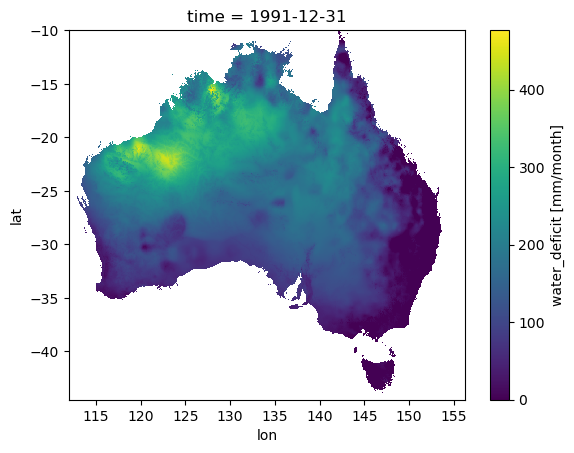

In [50]:
da_cwd[11,:,:].plot()

## 4. Calculate climatology of monthly water deficit

In [ ]:
da_netw[1,:,:].plot(size=3)

## Global CWD

In [ ]:
solar_dir= Path("/media/AsustorOne_Shared/ERA5Monthly/")
variable_dir=Path("/media/Modellingdata/")
chunks = {'time':-1}

precip_files = list(sorted(variable_dir.glob("*prec*.nc4")))

da_precip = xr.open_mfdataset(precip_files, 
                           preprocess=preprocess, 
                              chunks=chunks).prec.sel(time=slice("1991", '2020')) #"1991", '2020'

solar_files = list(sorted(solar_dir.joinpath("solar").glob("*solar*.nc")))

da_solar_mon = xr.open_mfdataset(solar_files, 
                           preprocess=preprocess, 
                              chunks=chunks).srad.sel(time=slice("1991", '2020')) #chunks=chunks

da_solar_mon.astype(np.float32)